In [6]:
# Check logits
import os
import matplotlib.pyplot as plt

folder_path =   '/network/scratch/s/sonia.joseph/imagenet_logits'

In [7]:
import json

# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'


# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Example usage
label = 0  # Replace with your label
class_name = get_class_name(label)
print(f"Class for label {label}: {class_name}")

class_name_to_lookup = "tiger_cat"  # Replace with your class name
label_from_class_name = get_label(class_name_to_lookup)
print(f"Label for class name '{class_name_to_lookup}': {label_from_class_name}")


Class for label 0: tench
Label for class name 'tiger_cat': 282


In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging

# Path to your ImageNet dataset
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Transformation for the data
data_transforms = transforms.Compose([
    # Add your transformations here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = DataLoader(imagenet_data, batch_size=60, shuffle=False)

# # Find max and min values of dataloader
# import torch

# # Assuming data_loader is already defined and loaded with (image, label) pairs

# # Initialize max and min labels. 
# # Use the first label for initialization if you want to avoid using infinities.
# min_label = float('inf')
# max_label = float('-inf')

# # Iterate over all batches in the data_loader
# for _, labels in data_loader:
#     # Update the max and min labels
#     min_label = min(min_label, torch.min(labels).item())
#     max_label = max(max_label, torch.max(labels).item())

# print("Minimum label:", min_label)
# print("Maximum label:", max_label)

In [10]:
# Function to get subset of dataset for a specific label
def get_subset_for_label(dataset, label_idx):
    # Find the index of the label
#     label_idx = dataset.class_to_idx[label]

    # Get indices of images with the specific label
    target_indices = [i for i, (_, target) in enumerate(dataset.samples) if target == label_idx]

    # Create a subset
    return Subset(dataset, target_indices)

# Specify your label here (folder name)
num_label = 'Egyptian_cat'
specific_label = int(get_label(num_label))
print(specific_label)

# Get the subset for the specific label
specific_label_subset = get_subset_for_label(imagenet_data, specific_label)

# Create a DataLoader for the subset
data_loader = DataLoader(specific_label_subset, batch_size=60, shuffle=False)

# Logging
print(f"ImageNet subset for label '{specific_label}' loaded. Total datapoints: {len(specific_label_subset)}")


285
ImageNet subset for label '285' loaded. Total datapoints: 50


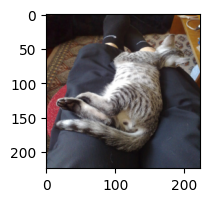

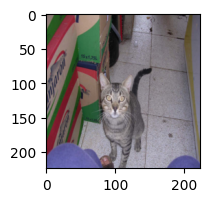

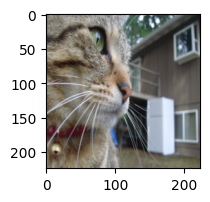

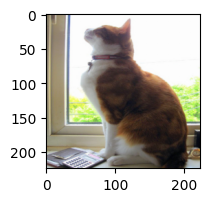

In [11]:
img, label = next(iter(data_loader))

max_count = 4
count = 0
for img, label in data_loader:
    for i in range(max_count):
        plt.figure(figsize=(2,2))
        plt.imshow(img[i].permute(1,2,0))



In [24]:
import h5py
import os
import numpy as np

# Path to your HDF5 file

def read_accuracies_from_file(file_path):
    """
    Reads a .txt file and extracts accuracy values formatted like "Accuracy for Layer 0, Head 0: 0.7198".

    :param file_path: Path to the .txt file.
    :return: A dictionary with the layer and head as keys and the accuracy as values.
    """
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if 'Accuracy for Layer' in line:
                    parts = line.strip().split(',')
                    parts = parts[-1].split(':')
                    acc = parts[-1].strip()
        return float(acc)
    except Exception as e:
        print(f"Error reading file: {e}")

def get_logits(ablation_type, parent_dir = '/network/scratch/s/sonia.joseph/imagenet_logits/'):
    load_path = os.path.join(parent_dir, ablation_type)
    with h5py.File(os.path.join(load_path, 'logits_and_labels.h5'), 'r') as h5f:
        logits = h5f['logits']
        labels = h5f['labels']
#         indices_of_specific_label = np.where(labels[:] == specific_label)[0]
#         specific_logits = logits_dataset[indices_of_specific_label]
        return logits[:], labels[:]

# def get_vanilla_logits(ablation_type='unablated', parent_dir = '/network/scratch/s/sonia.joseph/imagenet_logits/'):
#     load_path = os.path.join(parent_dir, ablation_type)
#     with h5py.File(os.path.join(load_path, 'logits_and_labels.h5'), 'r') as h5f:
#         logits_dataset = h5f['logits']
#         labels = h5f['labels']
#         return logits_dataset[:], labels[:]

from scipy.special import logsumexp


def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    
    :param x: A numpy array or a list of numbers.
    :return: A numpy array of softmax values.
    """
    # Convert input to a numpy array if it's not already
    x = np.array(x)
    
    # Calculate the exponentials of each element and the sum of those exponentials
    exp_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
    sum_exp_x = np.sum(exp_x)
    
    # Compute softmax
    return exp_x / sum_exp_x


def get_logit_diff(ablation_type, specific_label, parent_dir= '/network/scratch/s/sonia.joseph/imagenet_logits/'):
    
    vanilla_logits, labels = get_logits('unablated')
    ablated_logits, _ = get_logits(ablation_type)

    # Get datapoints for chosen label
    indices_of_specific_label = np.where(labels[:] == specific_label)[0]
    specific_vanilla = vanilla_logits[indices_of_specific_label]
    specific_ablated = ablated_logits[indices_of_specific_label]
    
    # Raw logit value
    raw_vanilla_logit = specific_vanilla[:, specific_label].mean()
    raw_ablated_logit = specific_ablated[:, specific_label].mean()
    
    raw_vanilla_softmax = softmax(specific_vanilla)[:, specific_label].mean()
    raw_ablated_softmax = softmax(specific_ablated)[:, specific_label].mean()
    
    # Get absolute difference
    abs_diff = specific_vanilla - specific_ablated
    abs_diff = abs_diff[:,specific_label]
    abs_diff = abs_diff.mean()
    
    abs_percent = abs_diff / specific_vanilla[:,specific_label].mean()
    
    # Get relative logit difference (difference between logit differences)
    all_indices_except_specific = [i for i in range(1000) if i != specific_label]
    vanilla_diff = specific_vanilla[:,all_indices_except_specific].mean() - specific_vanilla[:, specific_label].mean()
    ablated_diff = specific_ablated[:,all_indices_except_specific].mean() - specific_ablated[:, specific_label].mean()
    
    # try normalizing
    rel_diff = vanilla_diff - ablated_diff
    rel_percent = rel_diff / vanilla_diff
    
    lse_vanilla = logsumexp(specific_vanilla[:,all_indices_except_specific] - logsumexp(specific_vanilla[:, specific_label]))
    lse_ablated = logsumexp(specific_ablated[:,all_indices_except_specific] - logsumexp(specific_ablated[:, specific_label]))
    
    softmax_diff = softmax(specific_vanilla)[:,specific_label].mean() - softmax(specific_ablated)[:,specific_label].mean()
    softmax_percent = softmax_diff / softmax(specific_vanilla)[:,specific_label].mean()    
    
    data = {
        "raw_vanilla_logit": raw_vanilla_logit,
        "raw_ablated_logit": raw_ablated_logit,
        "raw_vanilla_softmax": raw_vanilla_softmax,
        "raw_ablated_softmax": raw_ablated_softmax,
        "abs_diff": abs_diff,
        "rel_diff": rel_diff,
        "-abs_percent": -abs_percent,
        "-rel_percent": -rel_percent,
        "lse_vanilla": lse_vanilla,
        "lse_ablated": lse_ablated,
        "softmax_diff": softmax_diff,
        "-softmax_percent": -softmax_percent
    }

    
    return data

In [25]:

head_idx = 1
ablation_type = f'layer{11}_head{head_idx}'


specific_label = 285
data = get_logit_diff(ablation_type, specific_label)

print(data)

{'raw_vanilla_logit': 10.346074, 'raw_ablated_logit': 10.210085, 'raw_vanilla_softmax': 0.012564647, 'raw_ablated_softmax': 0.011555272, 'abs_diff': 0.1359898, 'rel_diff': -0.13630486, '-abs_percent': -0.013144097, '-rel_percent': -0.013163475, 'lse_vanilla': -0.52464163, 'lse_ablated': -0.3135996, 'softmax_diff': 0.0010093749, '-softmax_percent': -0.080334514}


In [ ]:
specific_label = 285
indices_of_specific_label = np.where(labels[:] == specific_label)[0]


In [174]:
import numpy as np

abs_diff_all = np.zeros((24,12))
rel_diff_all = np.zeros((24,12))
abs_diff_percent = np.zeros((24,12))
rel_diff_percent = np.zeros((24,12))

lse_vanilla_all = np.zeros((24,12))
lse_ablated_all = np.zeros((24,12))

softmax_all = np.zeros((24,12))

for idx, layer_idx in enumerate(range(24)):
    try:
        if idx % 2 == 0: # attn
#             print('On attn layer', layer_idx//2)
            for head_idx in range(12):
                ablation_type = f'layer{layer_idx//2}_head{head_idx}'
                abs_diff, rel_diff, abs_percent, rel_percent, lse_vanilla, lse_ablated, softmax_diff, softmax_percent = get_logit_diff(ablation_type, specific_label)
                
                abs_diff_all[layer_idx, head_idx] = abs_diff
                rel_diff_all[layer_idx, head_idx] = rel_diff
                
                abs_diff_percent[layer_idx, head_idx] = abs_percent
                rel_diff_percent[layer_idx, head_idx] = rel_percent
                
                lse_vanilla_all[layer_idx, head_idx] = lse_vanilla
                lse_ablated_all[layer_idx, head_idx] = lse_ablated
                
                softmax_all[layer_idx, head_idx] = softmax_percent

#                 print(abs_diff, rel_diff, abs_percent, rel_percent)

        else:
#             print("On mlp layer", layer_idx//2)
            ablation_type = f'layer{layer_idx//2}_mlp'
            abs_diff, rel_diff, abs_percent, rel_percent, lse_vanilla, lse_ablated, softmax_diff, softmax_percent = get_logit_diff(ablation_type, specific_label)
            
            abs_diff_all[layer_idx] = abs_diff
            rel_diff_all[layer_idx] = rel_diff

            abs_diff_percent[layer_idx] = abs_percent
            rel_diff_percent[layer_idx] = rel_percent
                
            lse_vanilla_all[layer_idx] = lse_vanilla
            lse_ablated_all[layer_idx] = lse_ablated
            
            softmax_all[layer_idx] = softmax_percent

#             print(abs_diff, rel_diff, abs_percent, rel_percent)
    except Exception as e:
        print(e)
        
data = {
    'abs_diff_all': abs_diff_all.tolist(),
    'rel_diff_all': rel_diff_all.tolist(),
    'abs_diff_percent': abs_diff_percent.tolist(),
    'rel_diff_percent': rel_diff_percent.tolist(),
    'lse_vanilla': lse_vanilla.tolist(),
    'lse_ablated': lse_ablated.tolist(),
}


path_name = '/network/scratch/s/sonia.joseph/imagenet_logit_ablation_stats'
file_name = f'label_{specific_label}.json'

with open(os.path.join(path_name, file_name), 'w') as file:
    json.dump(data, file, indent=4)

    


vanila_sum 10.346074
ablated sum 10.344818
vanila_sum 10.346074
ablated sum 10.328677
vanila_sum 10.346074
ablated sum 10.269029
vanila_sum 10.346074
ablated sum 9.985273
vanila_sum 10.346074
ablated sum 9.953664
vanila_sum 10.346074
ablated sum 10.036282
vanila_sum 10.346074
ablated sum 10.21664
vanila_sum 10.346074
ablated sum 10.346338
vanila_sum 10.346074
ablated sum 10.200364
vanila_sum 10.346074
ablated sum 9.751878
vanila_sum 10.346074
ablated sum 10.246136
vanila_sum 10.346074
ablated sum 8.949906
vanila_sum 10.346074
ablated sum 2.2166939
vanila_sum 10.346074
ablated sum 10.245131
vanila_sum 10.346074
ablated sum 8.932358
vanila_sum 10.346074
ablated sum 10.182369
vanila_sum 10.346074
ablated sum 10.145457
vanila_sum 10.346074
ablated sum 9.561335
vanila_sum 10.346074
ablated sum 10.24262
vanila_sum 10.346074
ablated sum 10.209058
vanila_sum 10.346074
ablated sum 10.265273
vanila_sum 10.346074
ablated sum 10.294156
vanila_sum 10.346074
ablated sum 10.168871
vanila_sum 10.34607

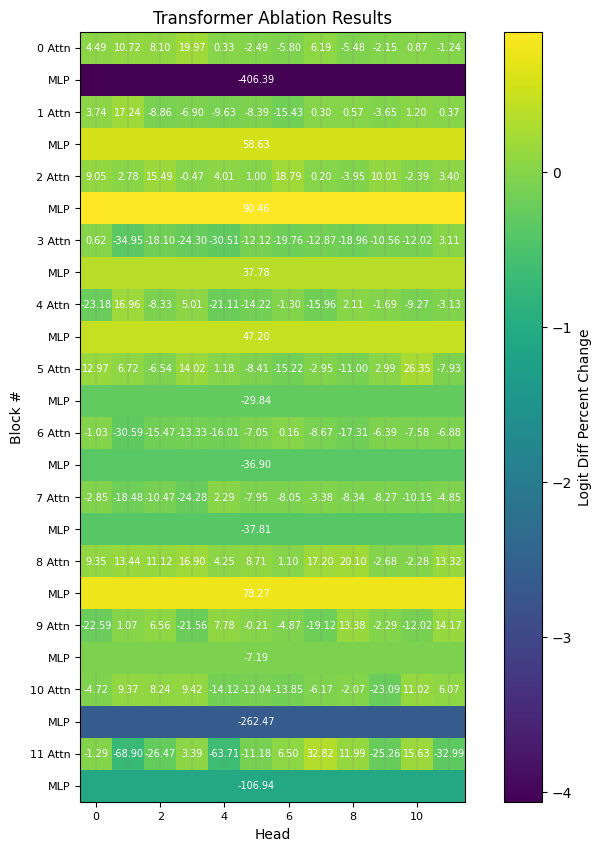

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming data (rel_diff_percent) is a 2D numpy array of shape (24, 12)
# data = abs_diff_percent
data = rel_diff_all
fig, axs = plt.subplots(figsize=(10, 10))

# Custom y-axis labels
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
axs.set_yticks(np.arange(0, 24, 1))
axs.set_yticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)])

axs.set_ylabel('Block #') 
axs.set_xlabel('Head')
axs.set_title('Transformer Ablation Results')

axs.tick_params(axis='both', which='major', labelsize=8)

# Heatmap
im = axs.imshow(data, cmap='viridis')
cbar = fig.colorbar(im)
cbar.set_label("Logit Diff Percent Change")

# Text annotations
fontsize = 7
for i in range(data.shape[0]):
    if i % 2 != 0:  # MLP layer
        text = axs.text(5, i, f'{data[i].mean()*100:.2f}', 
                        ha="center", va="center", color="w", fontsize=fontsize)
    else:  # Attn layer
        for j in range(data.shape[1]):
            text = axs.text(j, i, f'{data[i,j]*100:.2f}', 
                           ha="center", va="center", color="w", fontsize=fontsize)

# Grid lines for Attn layers
for i in range(0, 24, 2): 
    for j in range(12): 
        axs.vlines(j, i - 0.5, i + 0.5, colors='gray', linestyles='-', linewidth=0.2)



save_dir = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/figures/ablations'
fig_name = 'head-by-head-ablations.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')

plt.show()



In [ ]:
# Getting confused about normalizations
# I need to 

In [94]:
data.mean(axis=1)

array([-0.54112205,  5.65271711, -0.44539122, -0.64583874, -0.43100652,
       -0.91438472, -0.37670724, -0.20482385, -0.46405586, -0.73866713,
       -0.5148891 , -0.38825226, -0.43518571, -0.29650545, -0.44145446,
        0.4698143 , -0.56927156, -0.68833792, -0.41111081,  0.11156344,
       -0.43323642, -0.17154646, -0.42840948,  0.4712106 ])

In [156]:
# Get layer-level ablations for attention, instead of head-by-head
data_layer_level = data.copy()
for idx, layer_idx in enumerate(range(24)):
#     print(f"On layer_idx {layer_idx}")
    try: 
        if idx % 2 == 0: # attn
            print("On attn layer", {idx // 2})
            ablation_type = f'layer{layer_idx//2}_headNone'
            abs_diff, rel_diff, abs_percent, rel_percent, lse_vanilla, lse_ablated, softmax_diff, softmax_percent = get_logit_diff(ablation_type, specific_label)
            print(type(softmax_percent))
            data_layer_level[layer_idx] = softmax_diff
        else:
            continue # keep existing mlp data
    except Exception as e:
#         data_layer_level[layer_idx] = np.nan
        print(e)


On attn layer {0}
<class 'numpy.float32'>
On attn layer {1}
<class 'numpy.float32'>
On attn layer {2}
<class 'numpy.float32'>
On attn layer {3}
<class 'numpy.float32'>
On attn layer {4}
<class 'numpy.float32'>
On attn layer {5}
<class 'numpy.float32'>
On attn layer {6}
<class 'numpy.float32'>
On attn layer {7}
<class 'numpy.float32'>
On attn layer {8}
<class 'numpy.float32'>
On attn layer {9}
<class 'numpy.float32'>
On attn layer {10}
<class 'numpy.float32'>
On attn layer {11}
<class 'numpy.float32'>


In [35]:
# Get head-by-head ablations
import json


def numpy_to_native(data):
    """Converts a structure (possibly containing numpy types) to native Python types."""
    if isinstance(data, np.ndarray):
        return numpy_to_native(data.tolist())  # Converts numpy array to list
    elif isinstance(data, (np.float32, np.float64, np.int32, np.int64)):
        return float(data)  # Converts numpy numbers to Python float
    elif isinstance(data, list):
        return [numpy_to_native(item) for item in data]  # Recursively process each item in the list
    elif isinstance(data, dict):
        return {key: numpy_to_native(value) for key, value in data.items()}  # Process each key-value pair
    else:
        return data  
    
total_head_level_data = np.empty((24,12), dtype=object)
# for idx, layer_idx in enumerate(range(24)):
# #     try:
#     if idx % 2 == 0: # attn
#         for head_idx in range(12):
#             ablation_type = f'layer{layer_idx//2}_head{head_idx}'
#             data = get_logit_diff(ablation_type, specific_label)
#             print(type(data))
#             total_head_level_data[layer_idx, head_idx] = get_logit_diff(ablation_type, specific_label)

#     else:
#         ablation_type = f'layer{layer_idx//2}_mlp'
#         total_head_level_data[layer_idx] = get_logit_diff(ablation_type, specific_label)
# #     except Exception as e:
# #         print"(e)

# Get layer-level ablations for attention, instead of head-by-head
total_layer_level_data = total_head_level_data.copy()
for idx, layer_idx in enumerate(range(24)):
    try: 
        if idx % 2 == 0: # attn
            print("On attn layer", {idx // 2})
            ablation_type = f'layer{layer_idx//2}_headNone'
            data = get_logit_diff(ablation_type, specific_label)
            total_layer_level_data[layer_idx] = data
        else:
            continue # keep existing mlp data
    except Exception as e:
        print(e)


        
data = {
    'head_level': numpy_to_native(total_head_level_data),
    'layer_level': numpy_to_native(total_layer_level_data),
}

file_name = f'label_{specific_label}.json'

save_dir = ''
with open(os.path.join(save_dir, file_name), 'w') as file:
    json.dump(data, file, indent=4)


On attn layer {0}
On attn layer {1}
On attn layer {2}
On attn layer {3}
On attn layer {4}
On attn layer {5}
On attn layer {6}
On attn layer {7}
On attn layer {8}
On attn layer {9}
On attn layer {10}
On attn layer {11}


In [100]:
total_data = '/network/scratch/s/sonia.joseph/imagenet_logit_ablation_stats/label_0.json'
with open(total_data, 'r') as file:
    data = json.load(file)
    

head_level = data['layer_level']

# Assuming `head_level` is your list of lists of dictionaries
extracted_values = []

for sublist in head_level:
    row = []
    for dictionary in sublist:
        # Extract the value associated with 'some_key', or use a default value (e.g., 0) if the key is not found
        value = dictionary.get('-rel_percent')  # Replace 'some_key' with the actual key you're interested in
        # Optionally, handle non-numeric values here
        row.append(value)
    extracted_values.append(row)

# Convert to NumPy array
matrix = np.array(extracted_values, dtype=np.float32)

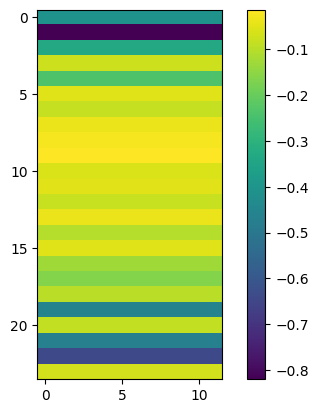

In [101]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(matrix)
plt.colorbar()

TypeError: Invalid shape () for image data

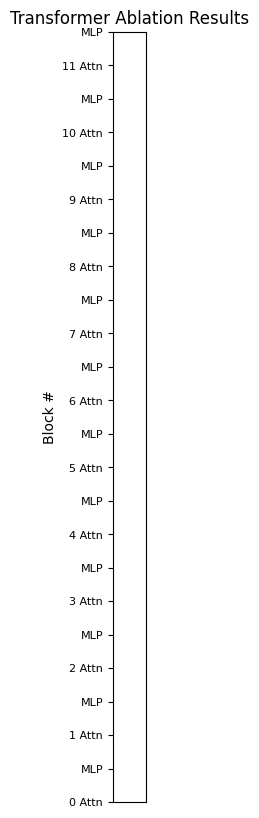

In [151]:


# Assuming 'data' is a numpy array with your results

fig, axs = plt.subplots(figsize=(10, 10))

# Setting custom y-axis labels
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
axs.set_yticks(np.arange(0, 24, 1))
axs.set_yticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)])  # Alternate labels

axs.set_ylabel('Block #') 
# axs.set_xlabel('Head')
axs.set_title('Transformer Ablation Results')
axs.set_xticks([])


axs.tick_params(axis='both', which='major', labelsize=8)


# Creating the heatmap
im = axs.imshow(data_layer_level, cmap='coolwarm')  # 'viridis' is just an example colormap, you can choose another
cbar = fig.colorbar(im)
cbar.set_label("Accuracy")

# Adding text annotations
fontsize=9
for i in range(data_layer_level.shape[0]):
    text = axs.text(5, i, f'{data[i,j]*100:.1f}%',
                        ha="center", va="center", color="w", fontsize=fontsize)

    
fig_name = 'layer-by-layer-ablations.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')
plt.show()


In [142]:
data_layer_level

array([[-0.48193228, -0.48193228, -0.48193228, -0.48193228, -0.48193228,
        -0.48193228, -0.48193228, -0.48193228, -0.48193228, -0.48193228,
        -0.48193228, -0.48193228],
       [-0.78580832, -0.78580832, -0.78580832, -0.78580832, -0.78580832,
        -0.78580832, -0.78580832, -0.78580832, -0.78580832, -0.78580832,
        -0.78580832, -0.78580832],
       [-0.37659392, -0.37659392, -0.37659392, -0.37659392, -0.37659392,
        -0.37659392, -0.37659392, -0.37659392, -0.37659392, -0.37659392,
        -0.37659392, -0.37659392],
       [-0.088857  , -0.088857  , -0.088857  , -0.088857  , -0.088857  ,
        -0.088857  , -0.088857  , -0.088857  , -0.088857  , -0.088857  ,
        -0.088857  , -0.088857  ],
       [-0.25960931, -0.25960931, -0.25960931, -0.25960931, -0.25960931,
        -0.25960931, -0.25960931, -0.25960931, -0.25960931, -0.25960931,
        -0.25960931, -0.25960931],
       [-0.04241036, -0.04241036, -0.04241036, -0.04241036, -0.04241036,
        -0.04241036, -

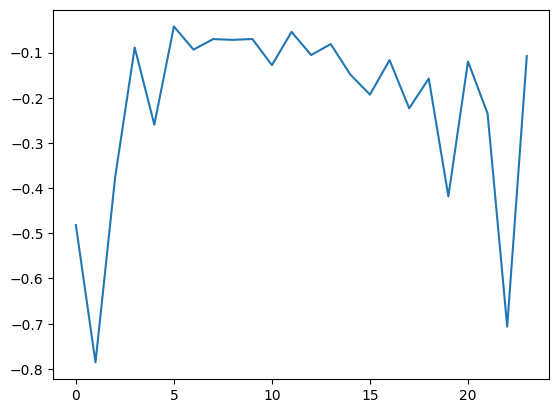

In [143]:
plt.figure()
plt.plot(data_layer_level. (axis=1))

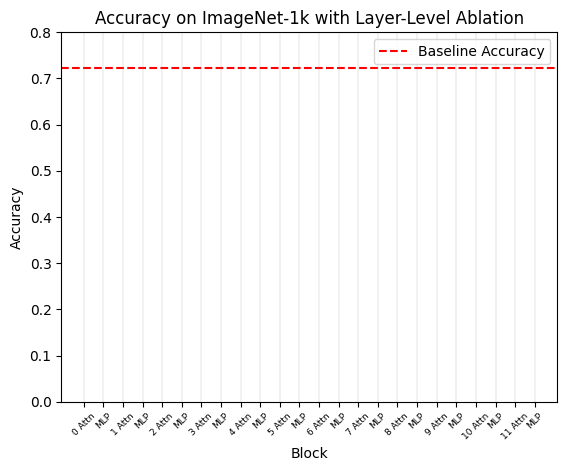

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data_layer_level' is a numpy array with your results

# Create a figure and an axes object
fig, ax = plt.subplots()

# Create a simple plot
ax.plot(range(24), data_layer_level[:,0])
ax.scatter(range(24), data_layer_level[:,0])
ax.set_title('Accuracy on ImageNet-1k with Layer-Level Ablation')
ax.set_xlabel('Block')
ax.set_ylabel('Accuracy')

# Show baseline accuracy
plt.axhline(y=vanilla_acc, color='r', linestyle='--', label='Baseline Accuracy')


# Adding custom tick marks for alternating Attn and MLP layers
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
ax.set_xticks(range(24))
ax.set_xticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)], rotation=45)  # Rotate for better readability
ax.tick_params(axis='x', labelsize=6.5)  # Adjust x-tick label size

ax.set_ylim(0, .8)
# Adding vertical lines for each x-tick
for x in range(24):
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=0.3, alpha=0.5)
    
plt.legend()

fig_name = 'layer-by-layer-ablations-graph.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')

plt.show()



In [20]:
import matplotlib.pyplot as plt

import numpy as np

def softmax_fn(x):
    # Apply softmax to an array (can be a vector or a matrix)
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)

# Open the HDF5 file
with h5py.File(os.path.join(save_path, 'logits_and_labels.h5'), 'r') as h5f:
    # Load the logits dataset
    logits_dataset = h5f['logits']
    labels = h5f['labels']
    
    idx = 200
    print(labels[idx])
        
    plt.figure()
    plt.bar(range(1000),logits_dataset[idx,:])
    plt.title(f"Logits of Unmodified ViT Patch 32 on ImageNet on Datapoint {idx}")
    
    softmax_data = softmax_fn(logits_dataset[idx,:])
    plt.figure()
    plt.bar(range(1000), softmax_data)
    plt.title(f'After softmax')

NameError: name 'save_path' is not defined

In [277]:
import timm
from vit_prisma.models.pretrained_model import PretrainedModel
from vit_prisma.configs.timmConfigs.vit_base_patch32_224_Config import GlobalConfig


model = timm.create_model('vit_base_patch32_224', pretrained=True)
new_head = model.head
del model
config = GlobalConfig()
new_model = PretrainedModel('vit_base_patch32_224', config, is_timm=True)
new_model.cuda()
new_head.cuda()

Linear(in_features=768, out_features=1000, bias=True)

In [299]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import re

# Assuming 'activations_dict' is your dictionary of activations
# and 'labels' is a tensor of the true labels for the activations
# Also assuming 'new_head' is your trained linear layer

imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'


# 1. Load and preprocess the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = DataLoader(imagenet_data, batch_size=64, shuffle=False)

# Move the new head to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_count = 1000
count = 0

accuracies = {} 
pattern = r'model\.blocks\.\d+$'  # This pattern matches strings like 'model.blocks.0', 'model.blocks.1', etc.

batch_size = 16

def ensure_key_exists(dictionary, key, default_value):
    dictionary.setdefault(key, default_value)
    
def ensure_key_matches_pattern_and_exists(dictionary, key, pattern, default_value):
    if re.match(pattern, key):
        dictionary.setdefault(key, default_value)
        
for images, labels in tqdm(data_loader):
    # Loop through each layer's activations
    for idx in range(batch_size):
        image, label = images[idx].cuda(), labels[idx].cuda()
        true_label = label.item()  # Convert the single-element tensor to an integer
        activations = new_model.get_activations(image.unsqueeze(0))
        for layer_name, layer_activations in activations.items():

            ensure_key_matches_pattern_and_exists(accuracies, layer_name, pattern, [])

            # If the layer name does not match the pattern, skip it
            if not re.match(pattern, layer_name):
                continue

            layer_activations = layer_activations.to(device)
            print(layer_activations.shape)

            with torch.no_grad():
                outputs = new_head(layer_activations[:,30,:])

            _, predicted = torch.max(outputs, 1)

            # Since we're evaluating on a single example, we take the first (and only) item
            predicted_label = predicted.item()

            # Now we can compare the true label with the predicted label directly
            correct = (predicted_label == true_label)

            # Compute accuracy (it will be 1.0 if correct, 0.0 otherwise)
            acc = float(correct)

#             ensure_key_exists(accuracies, 'model.blocks.0.norm1', [])

            accuracies[layer_name].append(acc)

#             print(f'Accuracy for layer {layer_name}: {acc:.2f}')

        count += 1
        if count > total_count:
#             print(count)
            break

    #         print("Breaking for...", layer_name)


  0%|          | 0/782 [00:00<?, ?it/s]

torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])


KeyboardInterrupt: 

In [ ]:
import statistics

In [301]:
means = {key: sum(value) / len(value) for key, value in accuracies.items() if value}
print(count)

92


In [304]:
# Initialize dictionaries to hold the means and variances
import numpy as np

means = {}
variances = {}

# Calculate the mean and variance for each list in the dictionary
for key, lst in accuracies.items():
    means[key] = np.mean(lst)
    variances[key] = np.var(lst, ddof=0)  # ddof=0 for population variance
    # Use ddof=1 for sample variance: np.var(lst, ddof=1)

print("Means:", means)
print("Variances:", variances)


Means: {'model.blocks.0': 0.0, 'model.blocks.1': 0.0, 'model.blocks.2': 0.0, 'model.blocks.3': 0.010869565217391304, 'model.blocks.4': 0.010869565217391304, 'model.blocks.5': 0.010869565217391304, 'model.blocks.6': 0.05434782608695652, 'model.blocks.7': 0.06521739130434782, 'model.blocks.8': 0.17391304347826086, 'model.blocks.9': 0.34782608695652173, 'model.blocks.10': 0.5, 'model.blocks.11': 0.6521739130434783}
Variances: {'model.blocks.0': 0.0, 'model.blocks.1': 0.0, 'model.blocks.2': 0.0, 'model.blocks.3': 0.010751417769376177, 'model.blocks.4': 0.010751417769376177, 'model.blocks.5': 0.010751417769376177, 'model.blocks.6': 0.05139413988657844, 'model.blocks.7': 0.0609640831758034, 'model.blocks.8': 0.14366729678638943, 'model.blocks.9': 0.226843100189036, 'model.blocks.10': 0.25, 'model.blocks.11': 0.22684310018903595}


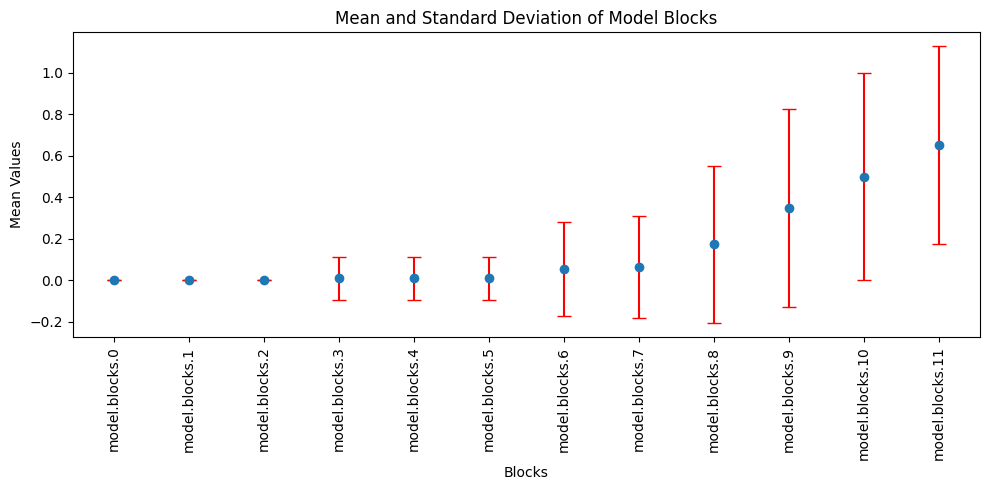

In [305]:
import matplotlib.pyplot as plt
# Filter out the keys where the mean or variance is NaN
keys = [k for k in means.keys() if not np.isnan(means[k]) and not np.isnan(variances[k])]
means_filtered = [means[k] for k in keys]
variances_filtered = [variances[k] for k in keys]


variances_filtered = [variances[k] for k in keys]

# Calculate the standard deviation from the variance
std_devs = np.sqrt(variances_filtered)

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(keys, means_filtered, yerr=std_devs, fmt='o', ecolor='red', capsize=5)
plt.xticks(rotation=90)  # Rotate the x labels to fit them nicely
plt.xlabel('Blocks')
plt.ylabel('Mean Values')
plt.title('Mean and Standard Deviation of Model Blocks')
plt.tight_layout()  
plt.show()